<a href="https://colab.research.google.com/github/tsourolampis/bu-cs630-fall23/blob/main/max_cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [6]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 20.2 MB/s eta 0:00:00


In [8]:
import pulp

In [26]:
def compute_cut_value(G, set_A, set_B):
    """
    Compute the value of the cut between two sets of nodes in a graph.

    Parameters:
    G (nx.Graph): The graph.
    set_A (set): The first set of nodes.
    set_B (set): The second set of nodes.

    Returns:
    int: The total weight of the edges that cross the cut.
    """
    cut_value = 0
    for edge in G.edges(data=True):
        # Check if the edge crosses the cut
        if (edge[0] in set_A and edge[1] in set_B) or (edge[0] in set_B and edge[1] in set_A):
            # Add the edge's weight to the cut value
            cut_value += edge[2].get('weight', 1)  # default weight is 1 if not specified
    return cut_value


{(0, 1): Text(-0.10160919054090849, 0.46966117506684757, '5'),
 (0, 2): Text(0.26654201479975304, 0.446503184637992, '3'),
 (1, 2): Text(0.11331207196238349, 0.08383564029516063, '4'),
 (1, 3): Text(-0.2665420147997531, -0.4465031846379919, '2'),
 (2, 3): Text(0.10160919054090842, -0.46966117506684746, '1')}

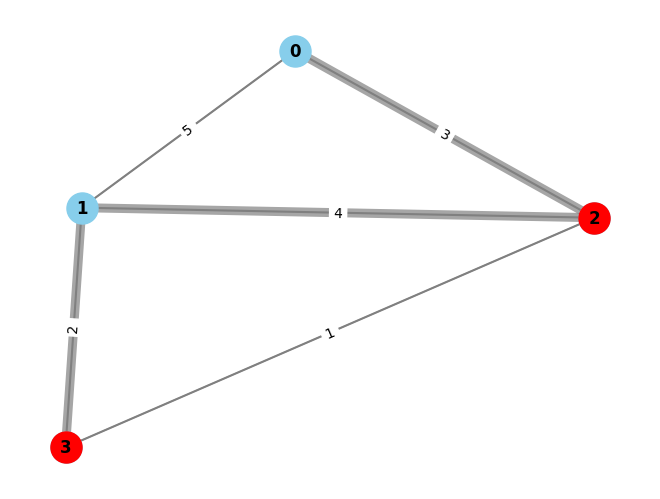

In [11]:
def max_cut_ilp_solver(graph):
    max_cut_problem = pulp.LpProblem("MaxCutProblem", pulp.LpMaximize)

    # Binary variables to represent the cut (1 if the node is in one set, 0 otherwise)
    nodes = list(graph.nodes())
    x = pulp.LpVariable.dicts("x", nodes, 0, 1, pulp.LpBinary)

    edges = list(graph.edges())
    y = pulp.LpVariable.dicts("y", edges, 0, 1, pulp.LpBinary)

    # Maximize the cut value (sum of edge weights crossing the cut)
    max_cut_problem += pulp.lpSum(graph[u][v]['weight'] * y[(u, v)] for (u, v) in edges), "MaximizeCut"

    # Add constraints y_uv <= x_u + x_v
    for (u, v) in edges:
        max_cut_problem += y[(u, v)] <= x[u] + x[v], f"Constraint_y_{u}_{v}_1"

    # Add constraints y_uv <= 2 - x_u - x_v
    for (u, v) in edges:
        max_cut_problem += y[(u, v)] <= 2 - x[u] - x[v], f"Constraint_y_{u}_{v}_2"

    # Solve the ILP problem
    max_cut_problem.solve()

    # Extract the results
    max_cut_value = pulp.value(max_cut_problem.objective)
    max_cut_set1 = [node for node in nodes if pulp.value(x[node]) == 1]
    max_cut_set2 = [node for node in nodes if pulp.value(x[node]) == 0]

    return max_cut_value, max_cut_set1, max_cut_set2

G = nx.Graph()
G.add_edge(0, 1, weight=5)
G.add_edge(0, 2, weight=3)
G.add_edge(1, 2, weight=4)
G.add_edge(1, 3, weight=2)
G.add_edge(2, 3, weight=1)

edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}



S = {2,3}
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_weight='bold', width=1.5, edge_color='gray')
# Draw the nodes in set S with a different color
nx.draw_networkx_nodes(G, pos, nodelist=S, node_color='red', node_size=500)

# Highlight the edges across the partition (S, V \ S) by increasing their width
edge_widths = [6.5 if (u in S and v not in S) or (u not in S and v in S) else 1.0 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='gray')

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)




In [12]:
max_cut_value, max_cut_set1, max_cut_set2 = max_cut_ilp_solver(G)
print("Max Cut Value:", max_cut_value)
print("Set 1:", max_cut_set1)
print("Set 2:", max_cut_set2)


Max Cut Value: 11.0
Set 1: [1]
Set 2: [0, 2, 3]


11

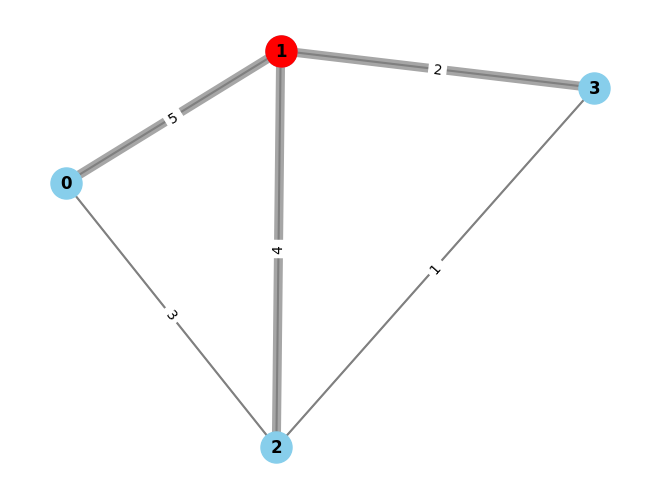

In [29]:


S = max_cut_set1
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_weight='bold', width=1.5, edge_color='gray')
# Draw the nodes in set S with a different color
nx.draw_networkx_nodes(G, pos, nodelist=S, node_color='red', node_size=500)

# Highlight the edges across the partition (S, V \ S) by increasing their width
edge_widths = [6.5 if (u in S and v not in S) or (u not in S and v in S) else 1.0 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='gray')

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)


compute_cut_value(G, max_cut_set1, max_cut_set2)


In [28]:
def max_cut_approx_weighted(G):
    # Initialize the two sets
    set_A = set()
    set_B = set()

    for node in G.nodes():
        weight_to_A = sum(G[node][neighbor]['weight'] for neighbor in G[node] if neighbor in set_A)
        weight_to_B = sum(G[node][neighbor]['weight'] for neighbor in G[node] if neighbor in set_B)

        # Assign the vertex to the set where the total weight of edges is smaller
        if weight_to_A > weight_to_B:
            set_B.add(node)
        else:
            set_A.add(node)

    return set_A, set_B

G = nx.Graph()
G.add_edge(0, 1, weight=5)
G.add_edge(0, 2, weight=3)
G.add_edge(1, 2, weight=4)
G.add_edge(1, 3, weight=2)
G.add_edge(2, 3, weight=1)

set_A, set_B = max_cut_approx_weighted(G)
print("Set A:", set_A)
print("Set B:", set_B)
compute_cut_value(G, set_A, set_B)

Set A: {0, 2, 3}
Set B: {1}


11

**Local search:** Another way to view this is as follows: we start with an  arbitrary cut, and then we keep modifying it greedily while there is a choice
that improves the size of the cut. Specifically,  while there exists a node $u$ such that moving $u$ to the other side of the cut would increase the cut value, we make such a move. We stop when such a move is no longer possible. Notice that we make a move when strict inequality holds, otherwise we could be making a long sequence of moves that do not improve the objective. This also gives a natural measure of progress to prove that the algorithm terminates.   Let $( S, V \setminus S)$ denote the final cut, and let $d(u, S)$ denote the contribution of the degree of u to the cut value $\delta(S)$. Then

$2 \cdot |\delta(S)| = \sum_{u \in S} d(u, S) + \sum_{v \in V \setminus S} d(v, S) \geq \sum_{u \in S} \frac{\text{deg}(u)}{2} + \sum_{v \in V \setminus S} \frac{\text{deg}(v)}{2} = \frac{1}{2} \sum_{x \in V} \text{deg}(x) = |E|, $

where the inequality holds due to the terminating condition of our algorithm.


In [27]:
import random

def randomized_halfapprox_max_cut(G):
    nodes = list(G.nodes())
    random.shuffle(nodes)
    mid = len(nodes) // 2
    set_A = set(nodes[:mid])
    set_B = set(nodes[mid:])

    # The cut_weight is not calculated as it is not used for determining the sets
    # If needed, it can be calculated by iterating over the edges

    return set_A, set_B

G = nx.Graph()
G.add_edge(0, 1, weight=5)
G.add_edge(0, 2, weight=3)
G.add_edge(1, 2, weight=4)
G.add_edge(1, 3, weight=2)
G.add_edge(2, 3, weight=1)

set_A, set_B = randomized_halfapprox_max_cut(G)

# Output the result
print("Set A:", set_A)
print("Set B:", set_B)

compute_cut_value(G, set_A, set_B)

Set A: {2, 3}
Set B: {0, 1}


9


**Random partition:**  Place each vertex in S (initially empty) independently with probability 1/2.  Then any edge  $e = \{u, v\} $ in E is cut if and only if exactly one of its endpoints is in S, and this occurs with probability 1/2. Thus, the expected contribution of e to $ \delta(S)$  is 1/2, so by linearity of expectation, the expected size of $\delta(S) $ is |E|/2.   

**Exercise**: what happens when the graph is weighted?

